In [1]:
# import the necessary utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

Import the processed data

In [2]:
data = pd.read_csv('processed_data.csv')
data.head(3)

,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Berri1,Maisonneuve_2,Maisonneuve_1
0,2009.0,1.0,1.0,-14.7,-19.9,-17.3,-23.125000,59.916667,28.291667,17.375000,29.0,35.0,20.0
1,2009.0,1.0,2.0,-11.3,-16.2,-13.8,-17.029167,76.250000,7.083333,12.250000,19.0,22.0,3.0
2,2009.0,1.0,3.0,-8.1,-13.0,-10.6,-15.441667,67.958333,28.208333,22.541667,24.0,22.0,12.0


Select the dataset to train on by typing into choices dictionnary: berri, maison2, maison1

In [3]:
choices = {'berri':"Berri1",'maison2':"Maisonneuve_2",'maison1':"Maisonneuve_1" }

selection = choices['berri']  #<- select by typing into here

y = data[selection].to_numpy()

In [4]:
#create custom bin sizes based on Freedman–Diaconis rule see: https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule
q3, q1 = np.percentile(y,[75,25])
bin_width = int(2*(q3-q1)/np.cbrt(len(y)))
bins = np.arange(0,max(y)+bin_width,bin_width)

To_categorize = np.arange(0,len(bins)-1,1)

data = data.assign(Berri1=pd.cut(data['Berri1'], 
                               bins=bins, 
                               labels=To_categorize))
data = data.assign(Maisonneuve_2=pd.cut(data['Maisonneuve_2'], 
                               bins=bins, 
                               labels=To_categorize))
data = data.assign(Maisonneuve_1=pd.cut(data['Maisonneuve_1'], 
                               bins=bins, 
                               labels=To_categorize))
bike_data=data

In [7]:
print(bins.shape, bin_width)

(18,) 549


In [9]:
columns_to_normalize = ['Max Temp (°C)',
                         'Min Temp (°C)',
                         'Mean Temp (°C)',
                         'Dew Point Temp (°C)',
                         'Rel Hum (%)',
                         'Wind Dir (10s deg)',
                         'Wind Spd (km/h)']

In [10]:
std_scaler = StandardScaler()
features = bike_data[columns_to_normalize]
scaled_features = std_scaler.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features, index=bike_data.index)
scaled_features.columns = columns_to_normalize
bike_data[columns_to_normalize] = scaled_features
#bike_data = bike_data.dropna() #using this removes the empty bins near the end that actually still have sparse datapoints

In [13]:
X = bike_data.drop(labels=['Berri1', 'Maisonneuve_2', 'Maisonneuve_1'],axis=1)
y= bike_data[selection]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10) 

knn = KNeighborsClassifier(n_neighbors=80, weights='distance',p=1)
knn.fit(X_train,y_train)
pred_train = knn.predict(X_train)
pred_test = knn.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('training set accuracy', acc_train.round(3))
print('test set accuracy', acc_test.round(3))


precision = precision_score(y_test, pred_test, average="macro", zero_division=0) # for each classes
print("precision: ",precision.round(3))
recall = recall_score(y_test, pred_test, average="macro", zero_division=0) # for each classes
print("recall: ",recall.round(3))
confusion = confusion_matrix(y_test, pred_test)
print("confusion: \n",confusion)

training set accuracy 1.0
test set accuracy 0.36
precision:  0.18
recall:  0.168
confusion: 
 [[79  2  1  0  0  0  0  0  0  0  0  0  0  0]
 [13  2  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 8  2  3  3  1  1  0  0  0  0  0  0  0  0]
 [ 2  3  2  1  2  0  1  1  0  3  0  0  0  0]
 [ 4  0  4  2  2  1  2  0  1  3  1  3  0  0]
 [ 3  1  4  1  0  0  1  3  0  8  2  2  0  0]
 [ 0  0  1  1  0  1  1  1  1  1  1  1  0  0]
 [ 0  0  1  1  0  2  2  0  2  2  5  3  0  0]
 [ 0  0  0  1  1  0  4  2  2  5  3  1  0  0]
 [ 0  0  0  0  0  1  0  3  5  5  4  4  0  0]
 [ 0  0  0  0  0  0  2  2  4  1  2  3  0  0]
 [ 0  0  0  0  0  0  1  0  1  2  1  1  0  0]
 [ 0  0  0  0  0  0  0  0  1  2  1  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0]]


In [9]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(knn, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('10-fold Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

10-fold Accuracy: 0.392 (0.021)


In [10]:
items_in_ytest = set(y_test)
n_items = len(items_in_ytest)

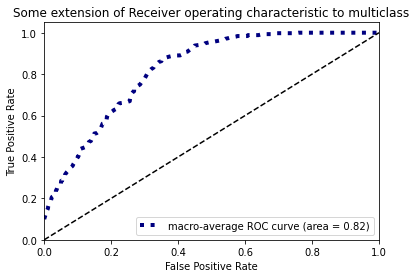

In [11]:
#check the classes in y_test

#y_test_list = list(set(y_test))

"""
blablabla
"""
pred_prob = knn.predict_proba(X_test)

y_test_dummies = pd.get_dummies(y_test, drop_first=False).values

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = {}

for i in range(n_items):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_items)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_items):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_items

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [12]:
np.save('results\\berri\\knn_out.npy',[pred_test,y_test])
np.save('results\\berri\knn_fpr_tpr.npy',[fpr['macro'],tpr['macro'],roc_auc])

G:\Anaconda\envs\comp6321\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
